In [1]:
import sys,os,os.path
sys.path.append("/Users/user/Desktop/PhD/Repositories/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
if not os.environ.get("ICTDIR"):
    os.environ["ICTDIR"] = "/Users/user/Desktop/PhD/Repositories/IC"

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db  import DataPMT, DataSiPM


from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [8, 6]
rcParams['font.size'] = 15


import re
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import tables

from scipy.spatial import cKDTree
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from   invisible_cities.database               import load_db

from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

In [2]:
import tables as tb

from sklearn.linear_model import RANSACRegressor
from scipy.stats import skewnorm, norm
from scipy.optimize import fsolve


In [3]:
detector_info = load_db.DataSiPM('next100', 0)

In [ ]:
def plot_sipms(sipm, energetic_sipm_mask, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]

    min_amplitude = 0.0
    mask = sipm_charge_time_summed > min_amplitude

    sipm_x_active = detector_info.X[mask]
    sipm_y_active = detector_info.Y[mask]

    def make_circle(x, y, radius):
        circle = patches.Circle((x, y), radius, edgecolor='r', facecolor='none', linestyle='--', linewidth=2
                                )
        return circle
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    #ax.add_patch(make_circle(sipm_x_max, sipm_y_max, 75))


    sipm_amplitude = sipm_charge_time_summed

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_active,
        sipm_y_active,
        c=sipm_amplitude[mask],
        cmap="viridis",
        s=10,
        label="Active SiPMs"
    )

    ax.scatter(
        sipm_x_all[energetic_sipm_mask],
        sipm_y_all[energetic_sipm_mask],
        edgecolor='r',
        facecolor='none',
        s=50,
        label=f"SiPMs within {radius_cut} mm"
    )

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title("SiPMs >3 sigma with 35mm padding & 25mm proximity cut")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()


def make_mask(sipm, radius_cut=75):

    sipm_charge_all = sipm.sum_over_times

    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    plt.hist(sipm_charge_all, bins=100, color='blue', alpha=0.7)
    # plot median and 3 sigma lines
    plt.axvline(sipm_charge_median, color='red', linestyle='--', label='Median')
    plt.axvline(sipm_charge_median + 3 * simp_charge_std, color='green', linestyle='--', label='Median + 3 sigma')
    plt.xlabel("SiPM charge (PEs)")
    plt.ylabel("Number of SiPMs")
    plt.title("Distribution of SiPM charges")
    plt.legend()

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm_charge_all > sipm_threshold

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y



    #sipm_x_max = detector_info.X[energetic_sipm_mask]
    #sipm_y_max = detector_info.Y[energetic_sipm_mask]
    #circle_mask = np.sqrt((sipm_x_all - sipm_x_max)**2 + (sipm_y_all - sipm_y_max)**2) < radius_cut
    
    return energetic_sipm_mask


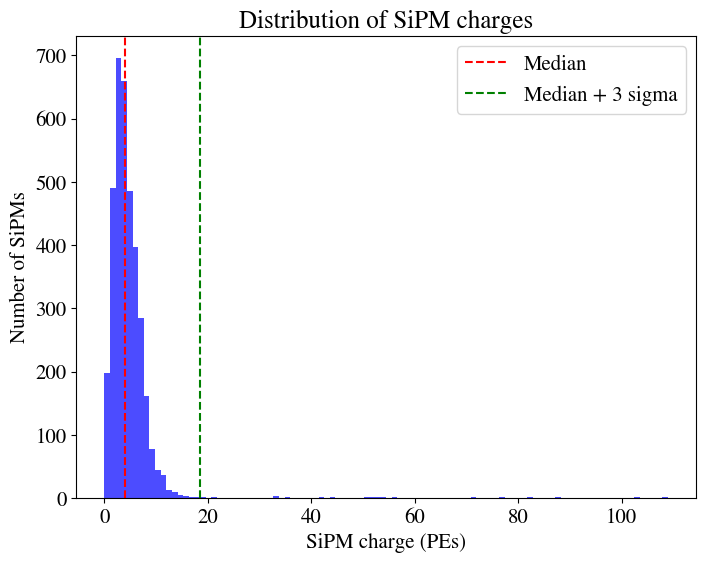

In [44]:
silly_stuff = make_mask(sipm, radius_cut=75)


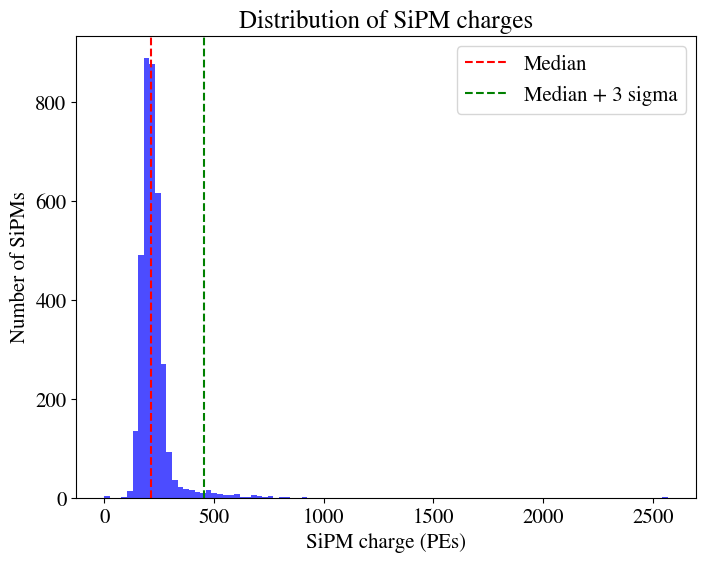

In [45]:
silly_stuff = make_mask(sipm_HE, radius_cut=75)


In [5]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/irene_files/15539/zero_cuts/run_15539_0001_ldc1.pmaps'

with tb.open_file(filename) as file:

    pmaps    = load_pmaps      (filename)
    pmt_info = file.root.PMAPS.S2Pmt
    sipm_info = file.root.PMAPS.S2Si

all_events = list(pmaps.keys())
s2 = pmaps[all_events[4]].s2s[0]
sipm = s2.sipms
pmt = s2.pmts

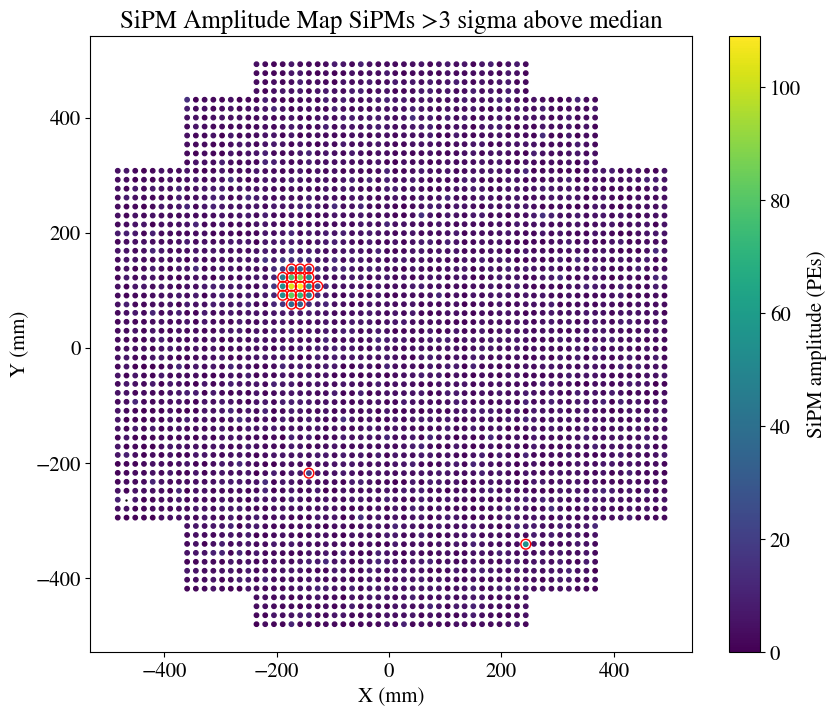

In [26]:
energetic_sipm_mask = make_mask(sipm, radius_cut=75)

plot_sipms(sipm, energetic_sipm_mask)

In [55]:
def make_mask(sipm, radius_cut=30, proximity_threshold=25):


    sipm_charge_all = sipm.sum_over_times

    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm_charge_all > sipm_threshold
    
    # Delete any SiPM that doesn't have any sipm passing the threshold within the proximity threshold
    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    
    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        # check if more than 1 energetic sipm is within the proximity threshold (including itself)
        if np.sum((distances < proximity_threshold) & energetic_sipm_mask) <= 1:
            energetic_sipm_mask[i] = False
    
    
    return energetic_sipm_mask

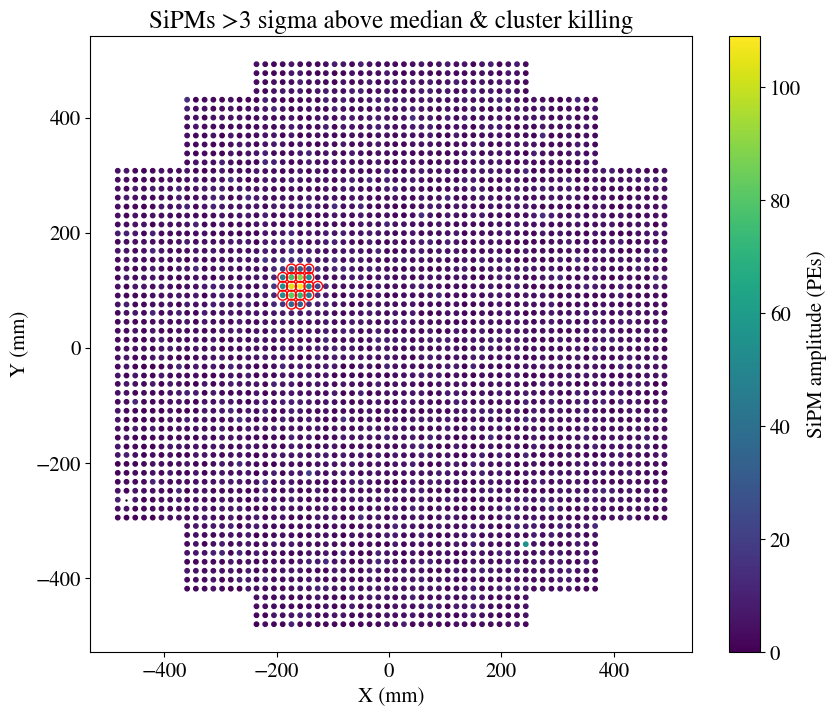

In [56]:
energetic_sipm_mask = make_mask(sipm, radius_cut=25, proximity_threshold=25)

plot_sipms(sipm, energetic_sipm_mask)

In [58]:
def make_mask(sipm, radius_cut=30):


    sipm_charge_all = sipm.sum_over_times

    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm_charge_all > sipm_threshold
    
    # create a circular mask around each selected SiPM and take the union of all these masks to get the final mask of SiPMs within the radius cut
    final_mask = np.zeros_like(energetic_sipm_mask, dtype=bool)

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        final_mask |= distances < radius_cut
    
    return final_mask

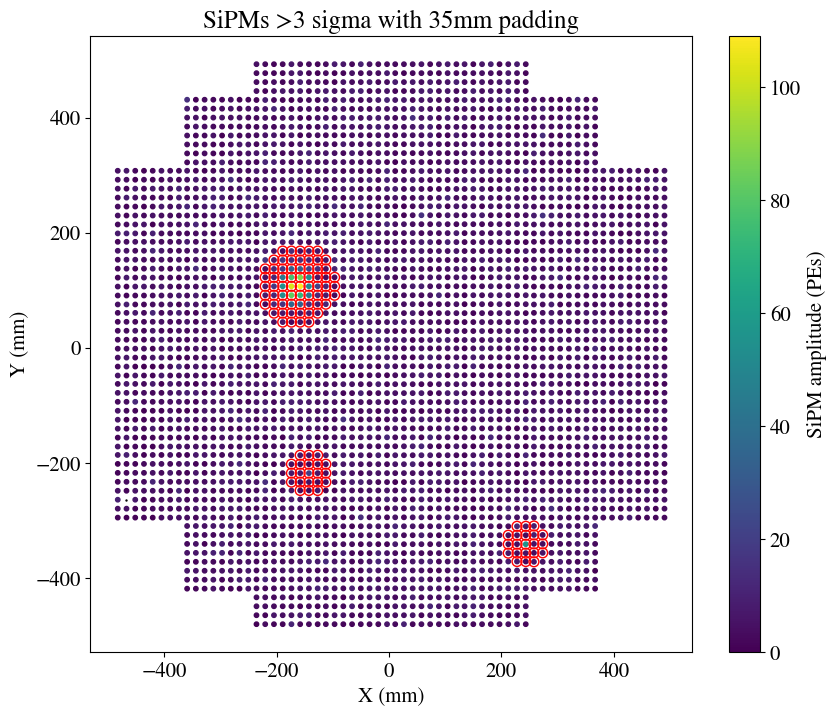

In [61]:
energetic_sipm_mask = make_mask(sipm, radius_cut=35)

plot_sipms(sipm, energetic_sipm_mask)

In [161]:
def make_mask(sipm, radius_cut=35, proximity_threshold=25):


    sipm_charge_all = sipm.sum_over_times

    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm_charge_all > sipm_threshold
    
    # create a circular mask around each selected SiPM and take the union of all these masks to get the final mask of SiPMs within the radius cut
    final_mask = np.zeros_like(energetic_sipm_mask, dtype=bool)

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        # check if more than 1 energetic sipm is within the proximity threshold (including itself)
        if np.sum((distances < proximity_threshold) & energetic_sipm_mask) <= 1:
            energetic_sipm_mask[i] = False
        
    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        final_mask |= distances < radius_cut
    
    return final_mask

In [162]:
energetic_sipm_mask = make_mask(sipm, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm, energetic_sipm_mask)

In [171]:
def fit_gaussian_to_sipm(sipm, mask, plot=False):

    # your data
    y = sipm.all_waveforms[mask].sum(axis=0)        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        plt.plot(x, y, label="Summed SiPM response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Charge (pes)")
        plt.title("SiPM response with selection mask")
        plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend(loc='upper right')
        plt.show()

    return variance, variance_err

def fit_gaussian_to_pmt(pmt, plot=False):

    # your data
    y = pmt.sum_over_sensors        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        # plot result fast
        plt.plot(x, y, label="Summed PMT response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Energt (pes)")
        plt.title("PMT response")
        plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err


def fit_gaussian_to_sipm_no_mask(sipm, plot=False):

    # your data
    y = sipm.sum_over_sensors       # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        plt.plot(x, y, label="Summed SiPM response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Charge (pes)")
        plt.title("SiPM response without selection mask")
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err

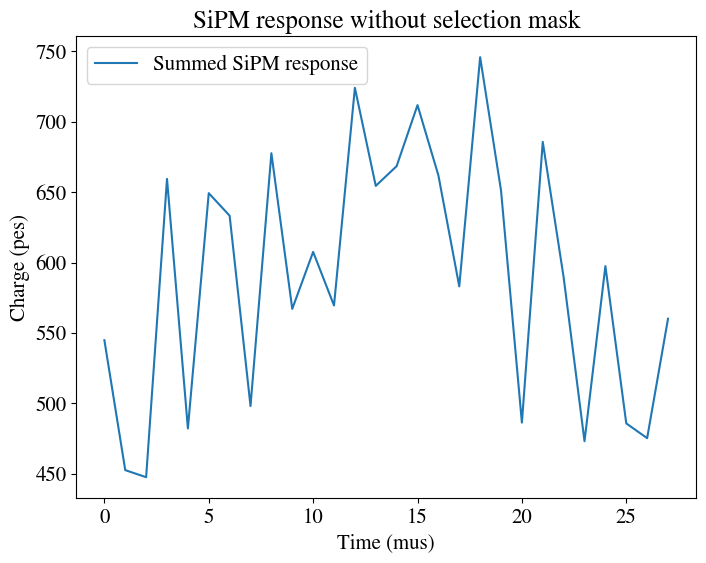

(45.97572565772981, 52.187670390076185)

In [172]:
fit_gaussian_to_sipm_no_mask(sipm, True)

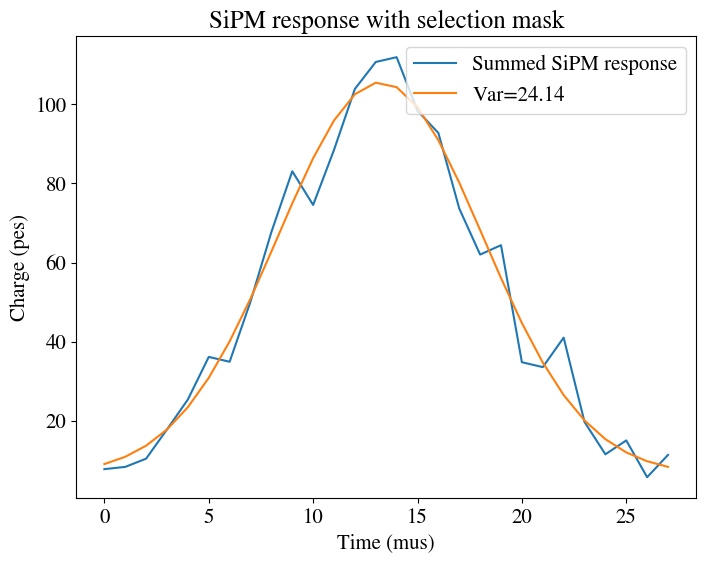

(24.141266649283367, 2.6650691916942795)

In [173]:
fit_gaussian_to_sipm(sipm, energetic_sipm_mask, True)

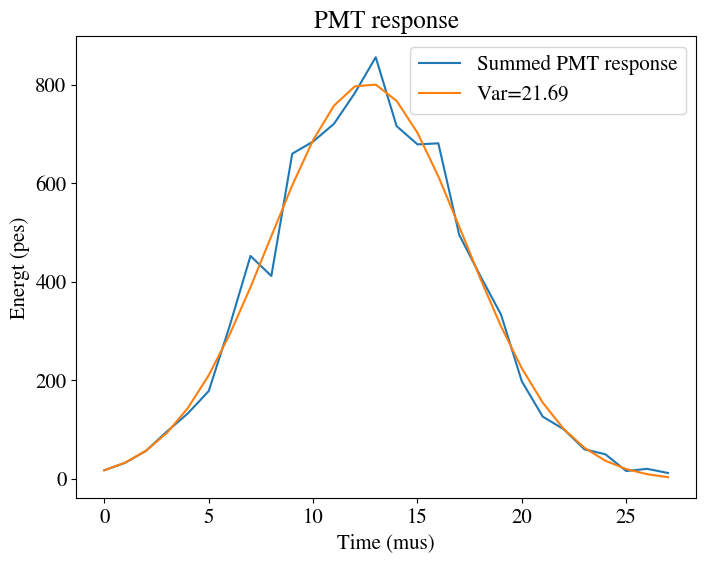

(21.68713098316758, 1.580585021101225)

In [174]:
fit_gaussian_to_pmt(pmt, True)

In [31]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/studying_HE_files/HE_data/one_event_pmap.pmaps'

with tb.open_file(filename) as file:

    pmaps_HE    = load_pmaps      (filename)
    pmt_info_HE = file.root.PMAPS.S2Pmt
    sipm_info_HE = file.root.PMAPS.S2Si

all_events_HE = list(pmaps_HE.keys())
s2_HE = pmaps_HE[all_events_HE[0]].s2s[4]
sipm_HE = s2_HE.sipms
pmt_HE = s2_HE.pmts



In [108]:
def plot_sipms(sipm, energetic_sipm_mask, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]


    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]

    min_amplitude = 0.001
    mask = sipm_charge_time_summed > min_amplitude
    mask_he = sipm_charge_time_summed < 2000
    mask = np.logical_and(mask, mask_he)

    sipm_x_active = detector_info.X[mask]
    sipm_y_active = detector_info.Y[mask]

    norm = mcolors.LogNorm(vmin=np.array(sipm_charge_time_summed[mask]).min(), vmax=np.array(sipm_charge_time_summed[mask]).max())

    def make_circle(x, y, radius):
        circle = patches.Circle((x, y), radius, edgecolor='r', facecolor='none', linestyle='--', linewidth=2
                                )
        return circle
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    #ax.add_patch(make_circle(sipm_x_max, sipm_y_max, 75))


    sipm_amplitude = sipm_charge_time_summed

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_active,
        sipm_y_active,
        c=sipm_amplitude[mask],
        cmap="viridis",
        s=10,
        #norm = norm,
        label="Active SiPMs"
    )

    ax.scatter(
        sipm_x_all[energetic_sipm_mask],
        sipm_y_all[energetic_sipm_mask],
        edgecolor='r',
        facecolor='none',
        s=50,
        label=f"SiPMs within {radius_cut} mm"
    )

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title("No mask #SiPMs >3 sigma above median with 50mm padding & 35mm procimity cut")#with 35mm padding & 25mm proximity cut with masked screamer")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()

def make_mask(sipm, radius_cut=35, proximity_threshold=25):

    sipm_charge_all = sipm.sum_over_times
    remove_screamer = sipm_charge_all < 2000
    sipm_charge_all = sipm_charge_all[remove_screamer]
    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm.sum_over_times > sipm_threshold


    #plt.hist(sipm_charge_all, bins=100, color='blue', alpha=0.7)
    # plot median and 3 sigma lines
    #plt.axvline(sipm_charge_median, color='red', linestyle='--', label='Median')
    #plt.axvline(sipm_charge_median + 3 * simp_charge_std, color='green', linestyle='--', label='Median + 3 sigma')
    #plt.xlabel("SiPM charge (PEs)")
    #plt.ylabel("Number of SiPMs")
    #plt.title("Distribution of SiPM charges")
    #plt.legend()

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    final_mask = np.zeros_like(energetic_sipm_mask, dtype=bool)

    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        # check if more than 1 energetic sipm is within the proximity threshold (including itself)
        if np.sum((distances < proximity_threshold) & energetic_sipm_mask) <= 1:
            energetic_sipm_mask[i] = False

    
    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        final_mask |= distances < radius_cut
    
    
    return final_mask




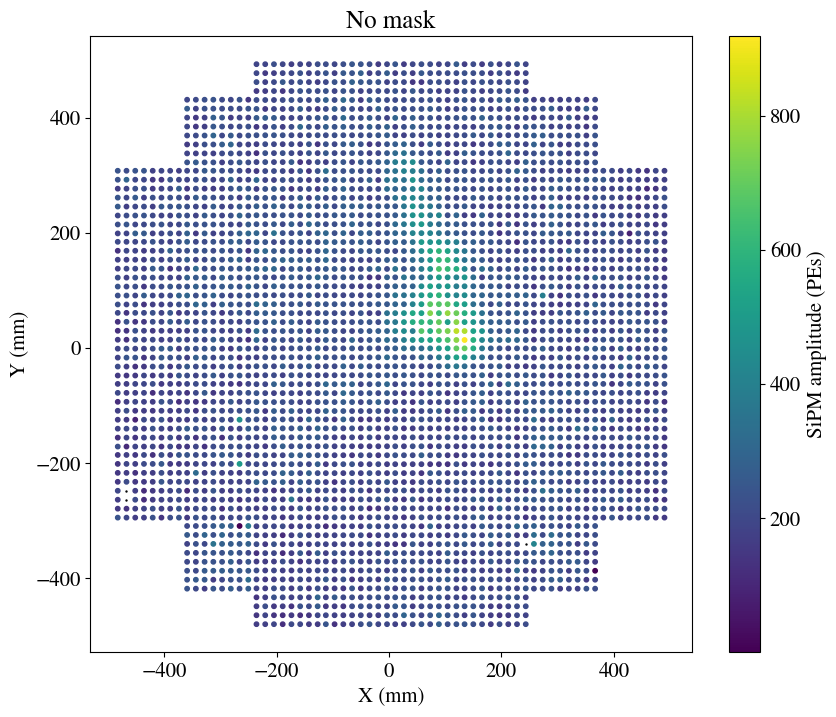

In [87]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

In [90]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

In [95]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=35)

plot_sipms(sipm_HE, energetic_sipm_mask)

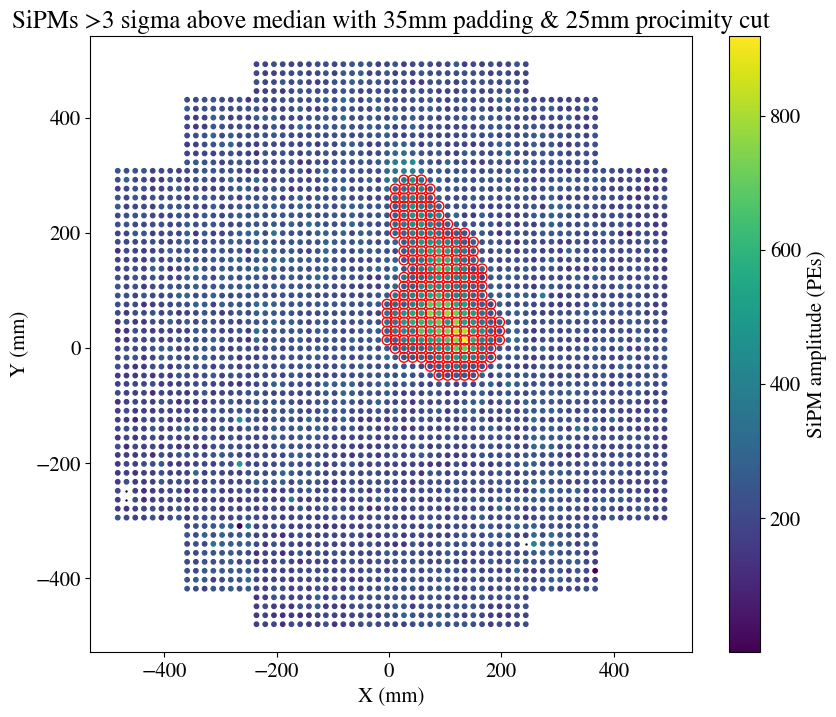

In [100]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

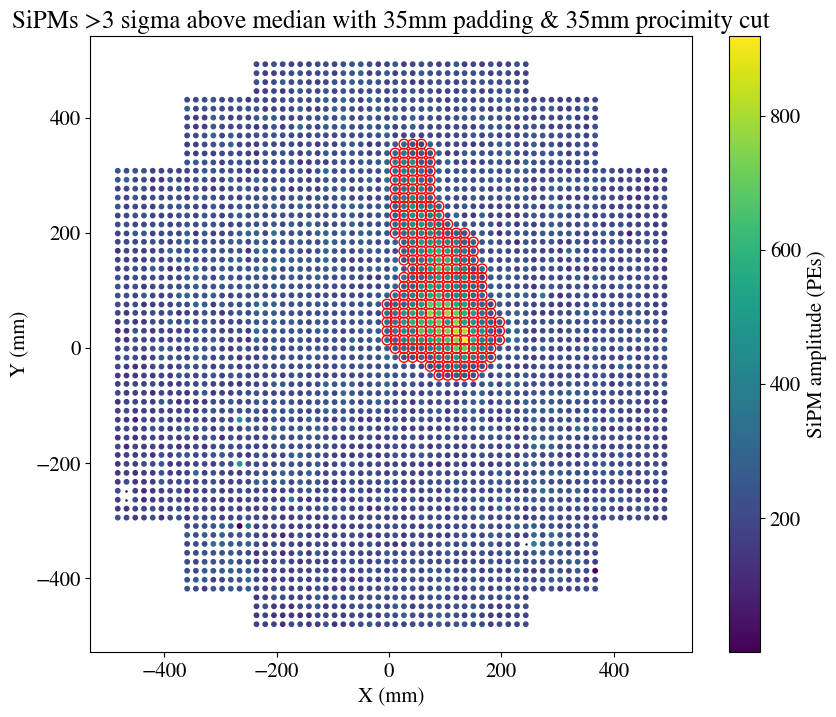

In [98]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=35)

plot_sipms(sipm_HE, energetic_sipm_mask)

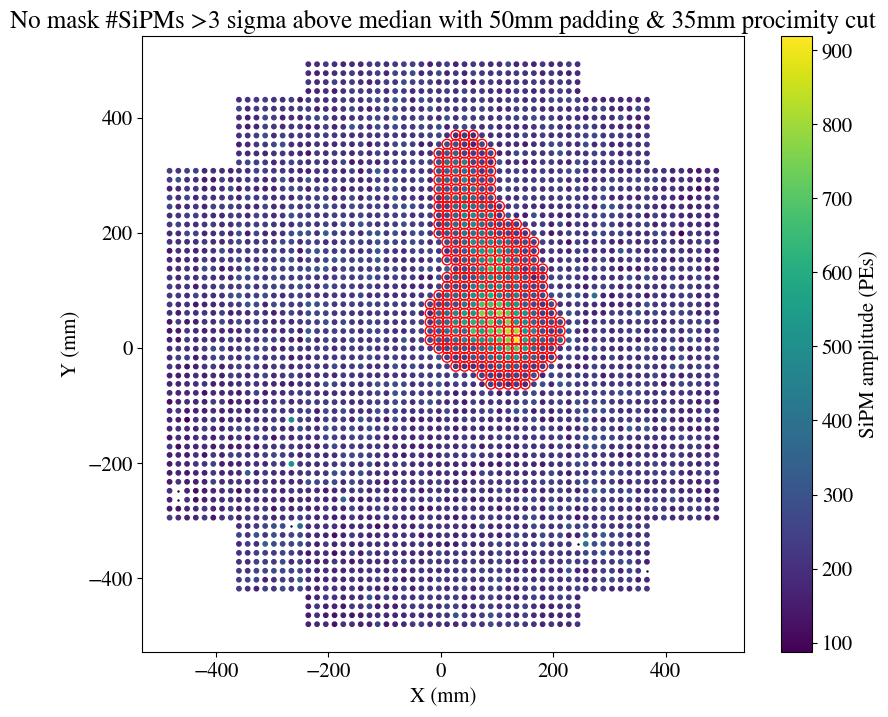

In [110]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=50, proximity_threshold=35)

plot_sipms(sipm_HE, energetic_sipm_mask)

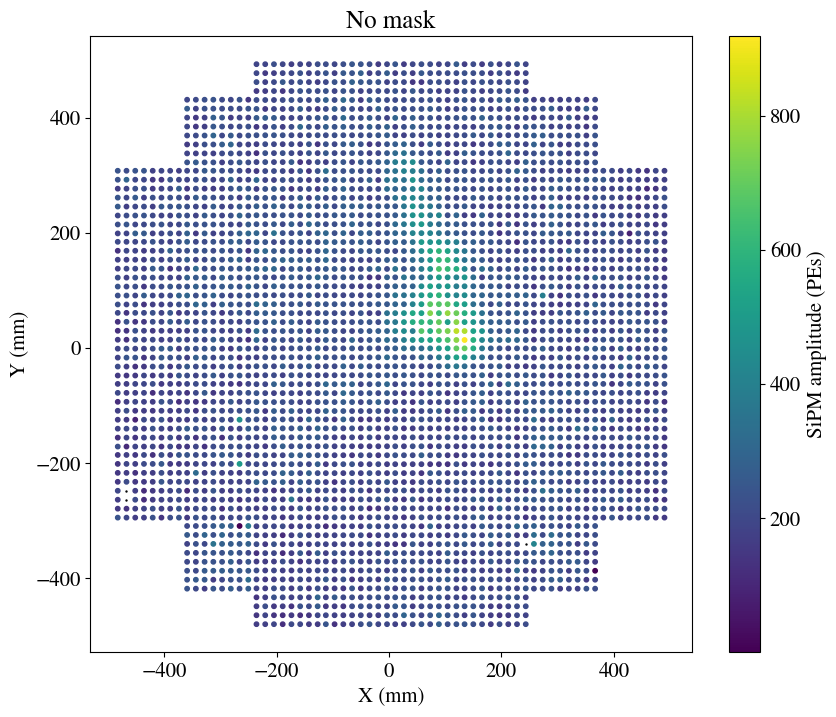

In [ ]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

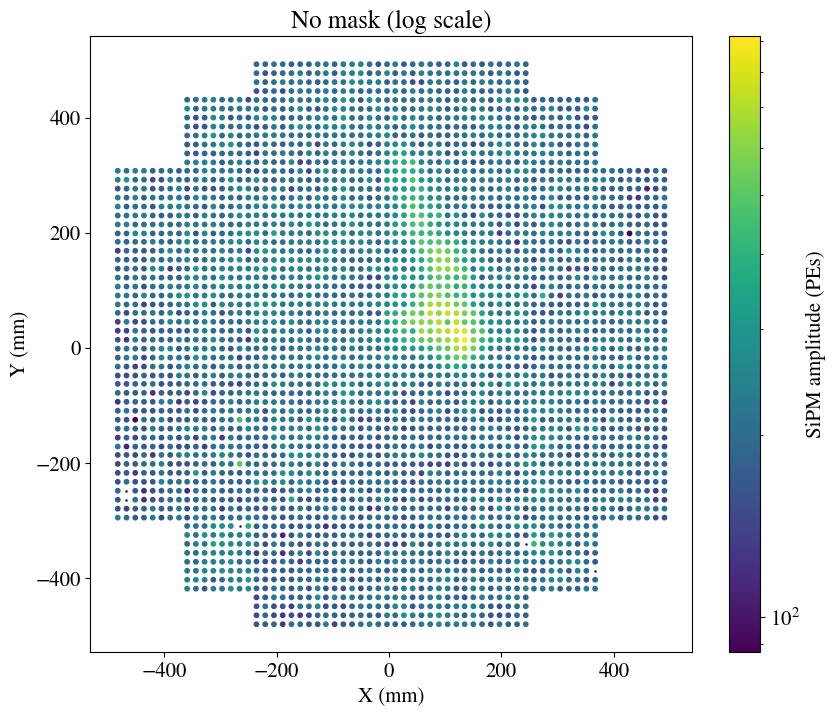

In [106]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

In [148]:
def fit_gaussian_to_sipm(sipm, mask, plot=False):

    # your data
    y = sipm.all_waveforms[mask].sum(axis=0)        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        plt.plot(x, y, label="Summed SiPM response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Charge (pes)")
        plt.title("SiPM response with selection mask")
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err

def fit_gaussian_to_pmt(pmt, plot=False):

    # your data
    y = pmt.sum_over_sensors        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        # plot result fast
        plt.plot(x, y, label="Summed PMT response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Energt (pes)")
        plt.title("PMT response")
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err


def fit_gaussian_to_sipm_no_mask(sipm, plot=False):

    # your data
    y = sipm.sum_over_sensors       # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        plt.plot(x, y, label="Summed SiPM response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Charge (pes)")
        plt.title("SiPM response without selection mask")
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err

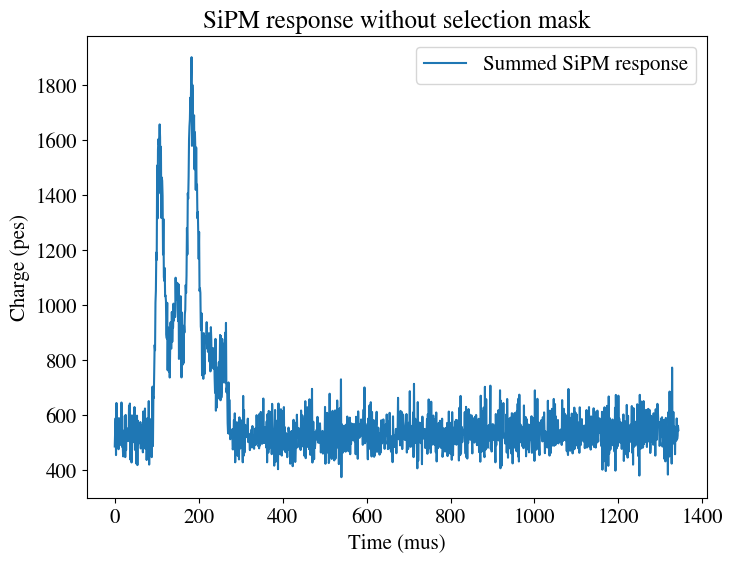

(2781.9329056752363, 144.36110618400488)

In [149]:
fit_gaussian_to_sipm_no_mask(sipm_HE, True)

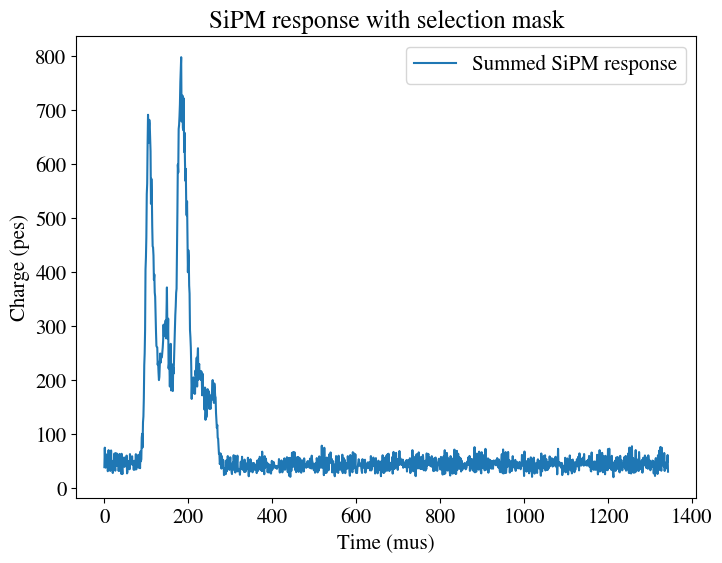

(2903.8410555404967, 141.05300704770642)

In [150]:
fit_gaussian_to_sipm(sipm_HE, energetic_sipm_mask, True)

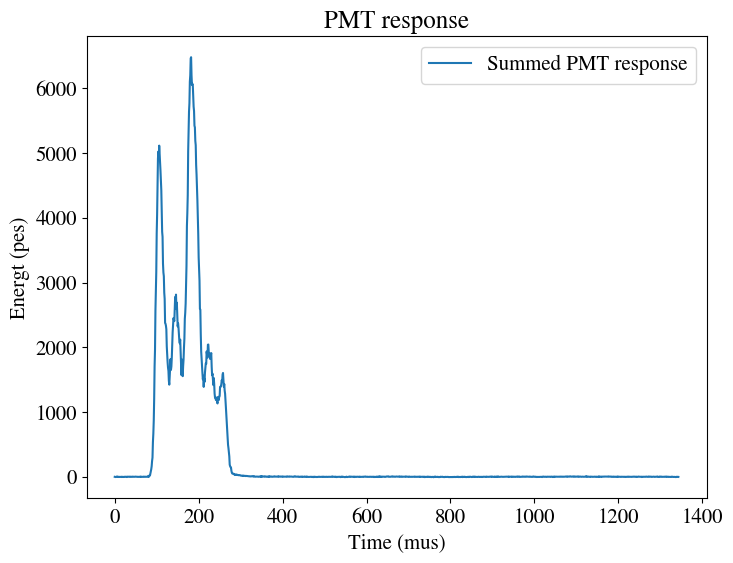

(2789.0183558546946, 115.6785248979779)

In [151]:
fit_gaussian_to_pmt(pmt_HE, True)

In [157]:
def fit_gaussian_to_pmt(pmt, plot=False):

    # your data
    y = pmt.sum_over_sensors        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        # plot result fast
        plt.plot(x, y, label="Summed PMT response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Energt (pes)")
        plt.title("PMT response")
        plt.xlim(50, 320)
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err


def fit_gaussian_to_sipm(sipm, mask, plot=False):

    # your data
    y = sipm.all_waveforms[mask].sum(axis=0)        # 1D array
    x = np.arange(len(y))            # sample index

    # Gaussian model
    def gauss(x, A, mu, sigma, c):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

    # initial guesses (robust enough for most S2 bumps)
    A0 = np.max(y) - np.min(y)
    mu0 = np.argmax(y)
    sigma0 = len(y) / 10
    c0 = np.min(y)

    p0 = [A0, mu0, sigma0, c0]

    # fit
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=p0)
    except RuntimeError:
        print("Error - curve_fit failed")
        return 0, 1000
    
    A, mu, sigma, c = popt
    A_err, mu_err, sigma_err, c_err = np.sqrt(np.diag(pcov))
    variance = sigma**2
    variance_err = 2 * sigma * sigma_err

    #print(f"Mean (mu)     = {mu:.2f}")
    #print(f"Sigma         = {sigma:.2f}")
    #print(f"Variance      = {variance:.2f}")

    if plot == True:
        plt.plot(x, y, label="Summed SiPM response")
        plt.xlabel("Time (mus)")
        plt.ylabel("Charge (pes)")
        plt.title("SiPM response with selection mask")
        plt.xlim(50, 320)
        #plt.plot(x, gauss(x, *popt), label=f"Var={variance:.2f}")
        plt.legend()
        plt.show()

    return variance, variance_err


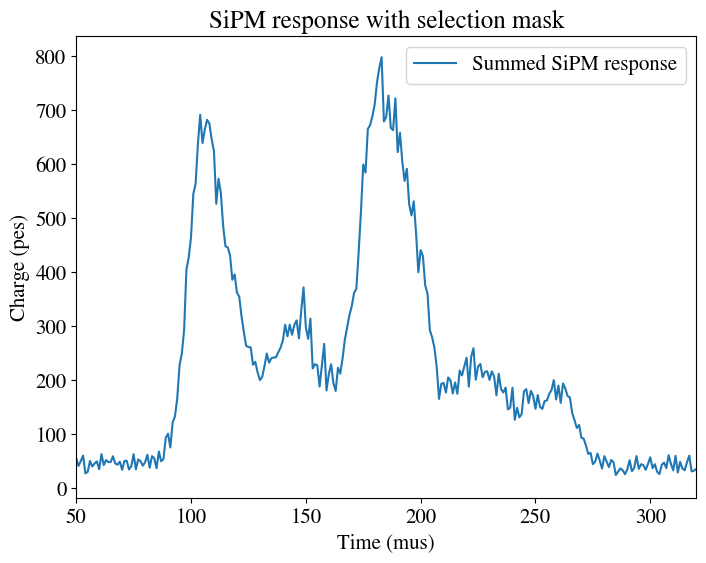

(2903.8410555404967, 141.05300704770642)

In [158]:
fit_gaussian_to_sipm(sipm_HE, energetic_sipm_mask, True)

In [159]:
fit_gaussian_to_pmt(pmt_HE, True)

(2789.0183558546946, 115.6785248979779)

In [193]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/studying_HE_files/HE_MC_data/hypathia_kr_0002.next.h5'

with tb.open_file(filename) as file:

    pmaps_HE_MC    = load_pmaps      (filename)
    pmt_info_HE_MC = file.root.PMAPS.S2Pmt
    sipm_info_HE_MC = file.root.PMAPS.S2Si

all_events_HE_MC = list(pmaps_HE_MC.keys())
s2_HE_MC_1 = pmaps_HE_MC[all_events_HE_MC[150]].s2s[0]
s2_HE_MC_2 = pmaps_HE_MC[all_events_HE_MC[150]].s2s[2]

sipm_HE_MC_1 = s2_HE_MC_1.sipms
pmt_HE_MC_1 = s2_HE_MC_1.pmts

sipm_HE_MC_2 = s2_HE_MC_2.sipms
pmt_HE_MC_2 = s2_HE_MC_2.pmts


In [192]:
pmaps_HE_MC[all_events_HE_MC[150]].s2s

(
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 84
        Times: [580.7     581.6229  582.55615 583.40405 584.52026 585.3563  586.4712
 587.5563  588.54254 589.6195  590.46436 591.4829  592.52985 593.5361
 594.52045 595.4981  596.5337  597.48395 598.4895  599.5078  600.5175
 601.4927  602.50146 603.49524 604.5051  605.4989  606.4988  607.5022
 608.4905  609.4958  610.50476 611.49945 612.49023 613.4944  614.492
 615.4876  616.48645 617.4813  618.48193 619.4856  620.482   621.4694
 622.4796  623.47974 624.4762  625.474   626.4722  627.4716  628.4769
 629.48535 630.48285 631.4772  632.4873  633.48914 634.4889  635.49567
 636.48    637.4916  638.4833  639.48724 640.47656 641.4746  642.4769
 643.48987 644.4855  645.478   646.4558  647.46796 648.46326 649.44275
 650.46045 651.45715 652.46027 653.4553  654.46594 655.46643 656.4538
 657.4019  658.41034 659.5396  660.42456 661.5687  662.16187 663.225  ] µs
        Time @ max energy: 

In [196]:
def plot_sipms(sipm, energetic_sipm_mask, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]


    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]

    min_amplitude = 0.001
    mask = sipm_charge_time_summed > min_amplitude
    mask_he = sipm_charge_time_summed < 2000
    mask = np.logical_and(mask, mask_he)

    sipm_x_active = detector_info.X[mask]
    sipm_y_active = detector_info.Y[mask]

    norm = mcolors.LogNorm(vmin=np.array(sipm_charge_time_summed[mask]).min(), vmax=np.array(sipm_charge_time_summed[mask]).max())

    def make_circle(x, y, radius):
        circle = patches.Circle((x, y), radius, edgecolor='r', facecolor='none', linestyle='--', linewidth=2
                                )
        return circle
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    #ax.add_patch(make_circle(sipm_x_max, sipm_y_max, 75))


    sipm_amplitude = sipm_charge_time_summed

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_active,
        sipm_y_active,
        c=sipm_amplitude[mask],
        cmap="viridis",
        s=10,
        #norm = norm,
        label="Active SiPMs"
    )

    ax.scatter(
        sipm_x_all[energetic_sipm_mask],
        sipm_y_all[energetic_sipm_mask],
        edgecolor='r',
        facecolor='none',
        s=50,
        label=f"SiPMs within {radius_cut} mm"
    )

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_title("No mask SiPMs >3")# sigma above median with 50mm padding & 35mm procimity cut")#with 35mm padding & 25mm proximity cut with masked screamer")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()

def make_mask(sipm, radius_cut=35, proximity_threshold=25):

    sipm_charge_all = sipm.sum_over_times
    remove_screamer = sipm_charge_all < 2000
    sipm_charge_all = sipm_charge_all[remove_screamer]
    sipm_charge_median = np.median(sipm_charge_all)
    simp_charge_std = np.std(sipm_charge_all)

    sipm_threshold = sipm_charge_median + 3 * simp_charge_std

    energetic_sipm_mask = sipm.sum_over_times > sipm_threshold


    #plt.hist(sipm_charge_all, bins=100, color='blue', alpha=0.7)
    # plot median and 3 sigma lines
    #plt.axvline(sipm_charge_median, color='red', linestyle='--', label='Median')
    #plt.axvline(sipm_charge_median + 3 * simp_charge_std, color='green', linestyle='--', label='Median + 3 sigma')
    #plt.xlabel("SiPM charge (PEs)")
    #plt.ylabel("Number of SiPMs")
    #plt.title("Distribution of SiPM charges")
    #plt.legend()


    
    return energetic_sipm_mask




In [ ]:
    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    final_mask = np.zeros_like(energetic_sipm_mask, dtype=bool)

    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        # check if more than 1 energetic sipm is within the proximity threshold (including itself)
        if np.sum((distances < proximity_threshold) & energetic_sipm_mask) <= 1:
            energetic_sipm_mask[i] = False

    
    for i in np.where(energetic_sipm_mask)[0]:
        x, y = sipm_x_all[i], sipm_y_all[i]
        distances = np.sqrt((sipm_x_all - x)**2 + (sipm_y_all - y)**2)
        final_mask |= distances < radius_cut
    

In [198]:
energetic_sipm_mask = make_mask(sipm_HE_MC_1, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE_MC_1, energetic_sipm_mask)

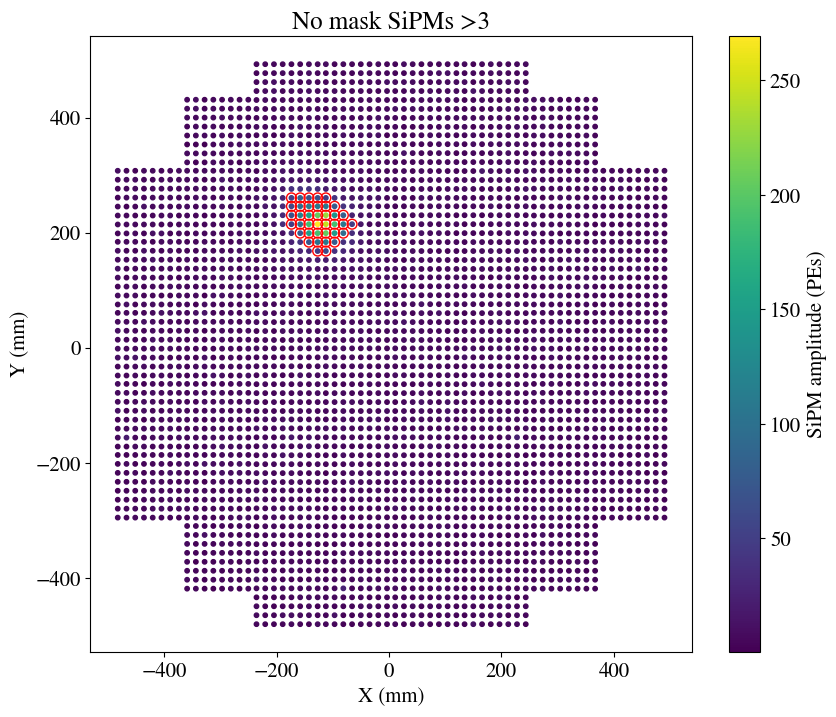

In [199]:
energetic_sipm_mask = make_mask(sipm_HE_MC_2, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE_MC_2, energetic_sipm_mask)

In [ ]:
energetic_sipm_mask = make_mask(sipm_HE, radius_cut=35, proximity_threshold=25)

plot_sipms(sipm_HE, energetic_sipm_mask)

In [369]:
sophronia_15539 = read_filtered_sophronia_files()